# Assignment 3
## Econ 8310 - Business Forecasting

For homework assignment 3, you will work with [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), a more fancier data set.

- You must create a custom data loader as described in the first week of neural network lectures [2 points]
    - You will NOT receive credit for this if you use the pytorch prebuilt loader for Fashion MNIST!
- You must create a working and trained neural network using only pytorch [2 points]
- You must store your weights and create an import script so that I can evaluate your model without training it [2 points]

Highest accuracy score gets some extra credit!

Submit your forked repository URL on Canvas! :) I'll be manually grading this assignment.

Some checks you can make on your own:
- Did you manually process the data or use a prebuilt loader (see above)?
- Does your script train a neural network on the assigned data?
- Did your script save your model?
- Do you have separate code to import your model for use after training?

In [1]:

import gzip, struct
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# read the gzipped IDX file and return it as a NumPy array.
def decode_idx(filepath):
  
    raw = open(filepath, 'rb').read()
    data = gzip.decompress(raw)
    _, _, dims = struct.unpack_from('>HBB', data, 0)
    offset = 4
    shape = []
    # read each dimension size ,4 bytes per dim
    for _ in range(dims):
        dim_size, = struct.unpack_from('>I', data, offset)
        shape.append(dim_size)
        offset += 4
    arr = np.frombuffer(data, dtype=np.uint8, offset=offset)
    return arr.reshape(shape)

#Custom Dataset rthat reads raw IDX gzip files.
# decode images and labels, then normalize images to [0.0, 1.0]
 # Convert to torch.Tensor
 
class IDXFashionDataset(Dataset):
    
    def __init__(self, imgs_path, lbls_path):
        images = decode_idx(imgs_path).astype(np.float32) / 255.0
        labels = decode_idx(lbls_path).astype(np.int64)
        self.X = torch.from_numpy(images).unsqueeze(1)  #  (N,1,28,28)
        self.Y = torch.from_numpy(labels)   #(N, )

    def __len__(self):
        return len(self.Y)
 # will return one (image, label) pair
    def __getitem__(self, idx):
        return self.X[idx], int(self.Y[idx])

In [2]:
 ##CNN model.   simple CNN with tw-convoloutional blocks 
# First conv block: 1→16 channels, 5×5 kernel, pad to keep spatial size 28×28 → pool to 14×14
# Second conv block: 16→32 channels, again 5×5 → pool to 7×7
class CNNModel(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 100),
            nn.ReLU(True),
            nn.Linear(100, 10)
        )
#apply conve blocks first then classifier
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.classifier(x)

 #here data will load, then train the CNN for 10 epochs, evaluate on the test set each epoch,
 #and then saves the best performing model weights
def execute_training():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_imgs = 'data/train-images-idx3-ubyte.gz'
    train_lbls = 'data/train-labels-idx1-ubyte.gz'
    test_imgs  = 'data/t10k-images-idx3-ubyte.gz'
    test_lbls  = 'data/t10k-labels-idx1-ubyte.gz'
#craet PyTorch Datasets and DataLoader
    train_ds = IDXFashionDataset(train_imgs, train_lbls)
    test_ds  = IDXFashionDataset(test_imgs,  test_lbls)
    train_ld = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_ld  = DataLoader(test_ds,  batch_size=256, shuffle=False)

    # Sanity check one batch
    sample_X, sample_y = next(iter(train_ld))
    print(f"[Sanity] X batch shape: {sample_X.shape}, y batch sample: {sample_y[:5].tolist()}")

    model = CNNModel().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_accuracy = 0.0
    #main trainingloop
    for epoch in range(1, 11):
        model.train()
        for X, y in train_ld:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()

        # After each epoch evaluate on test set 
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in test_ld:
                X, y = X.to(device), y.to(device)
                preds = model(X).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        accuracy = correct / total
        print(f"Epoch {epoch:2d}: Test Accuracy = {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'cnn_best_weights.pth')

    print(f"Best Test Accuracy Achieved: {best_accuracy:.4f}")

if __name__ == '__main__':
    execute_training()



[Sanity] X batch shape: torch.Size([64, 1, 28, 28]), y batch sample: [1, 1, 1, 0, 2]
Epoch  1: Test Accuracy = 0.8583
Epoch  2: Test Accuracy = 0.8886
Epoch  3: Test Accuracy = 0.8915
Epoch  4: Test Accuracy = 0.9029
Epoch  5: Test Accuracy = 0.8984
Epoch  6: Test Accuracy = 0.9104
Epoch  7: Test Accuracy = 0.9094
Epoch  8: Test Accuracy = 0.9036
Epoch  9: Test Accuracy = 0.9038
Epoch 10: Test Accuracy = 0.9152
Best Test Accuracy Achieved: 0.9152


Final Test Accuracy: 0.9152


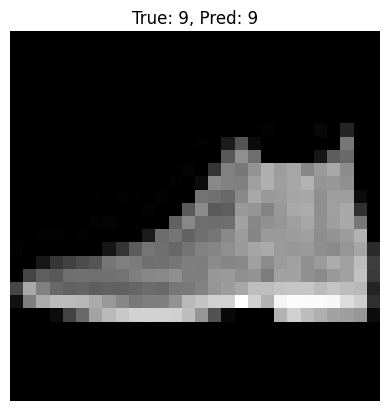

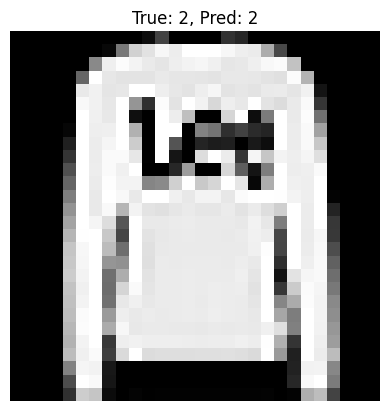

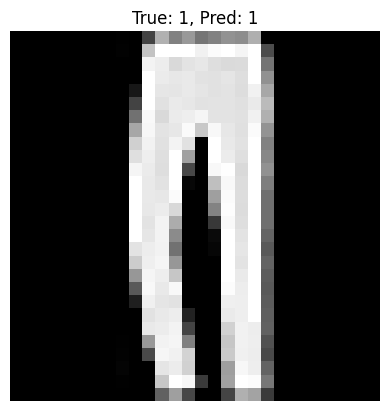

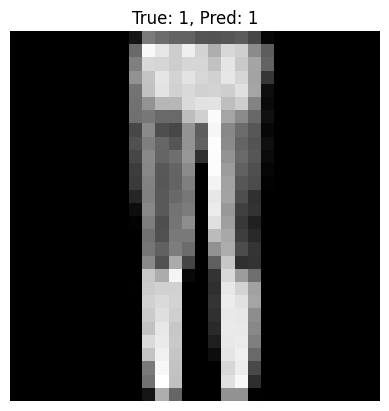

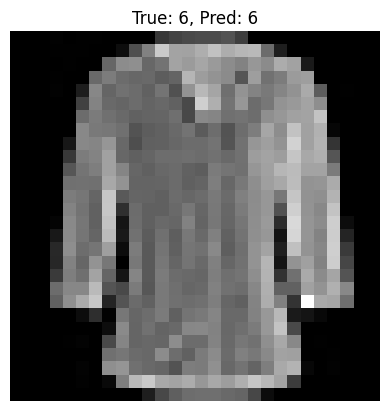

In [4]:

##############################
# eval_script.py

import matplotlib.pyplot as plt                      
import torch
from torch.utils.data import DataLoader
from train_script import CNNModel, IDXFashionDataset

def execute_inference():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # recreate test DataLoader
    test_ds = IDXFashionDataset(
        'data/t10k-images-idx3-ubyte.gz',
        'data/t10k-labels-idx1-ubyte.gz'
    )
    test_ld = DataLoader(test_ds, batch_size=256, shuffle=False)

    # Load model & saved weights
    model = CNNModel().to(device)
    model.load_state_dict(torch.load('cnn_best_weights.pth', map_location=device))
    model.eval()

    # compute overall test accuracy
    correct = total = 0
    with torch.no_grad():
        for X, y in test_ld:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    print(f"Final Test Accuracy: {correct/total:.4f}")

    
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_ld:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            # show first 5
            for i in range(5):
                img = X_batch[i].cpu().squeeze()      # convert to (28,28) 
                true_lbl = y_batch[i].item()
                pred_lbl = preds[i].item()
                plt.imshow(img, cmap='gray')
                plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
                plt.axis('off')
                plt.show()
            break   

if __name__ == '__main__':
    execute_inference()

